In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load and default preprocessing

In [2]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# time as index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

# delete rows where target == 0
dangjin_data = dangjin_data.loc[dangjin_data['dangjin_sum'] != 0]
ulsan_data = ulsan_data.loc[ulsan_data['ulsan'] != 0]

## Functions

In [3]:
def validate(model, data, x_cols, y_cols, test_size=0.2):
    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [4]:
def evaluate(predict, y):
    return abs(predict - y.iloc[:,0]).sum(axis=0)

## X and Y

In [5]:
x_cols_obs = ['Temperature_obs', 'Humidity_obs','Cloud_obs','Day_cos','Day_sin','Year_cos','Year_sin']
x_cols_fcst = ['Temperature_fcst','Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']

y_dangjin_cols = ['dangjin_sum']
y_ulsan_cols = ['ulsan']

## Experiment 1: Ensemble different timesteps (from 0,3,6,9)
-> 단순한 shift로는 성능 저하 심함

In [50]:
timesteps = [0,1,2,3]

def ensemble_timestep(data, x_cols, y_cols):
    predicts = []

    # test set size 미리 정하기. 비율로 split할 경우 ts별 size 불일치.
    test_size = int(data.shape[0] * 0.2)

    for ts in timesteps:
        print('='*50, ts, '='*50)

        # shift data
        data_shifted = data.copy()
        data_shifted[x_cols] = data_shifted[x_cols].shift(ts)
        data_shifted.dropna(inplace=True)

        # validate
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, random_state=27, n_estimators=100, min_samples_leaf=10)
        predict, test_y = validate(model, data_shifted, x_cols, y_cols, test_size=test_size)
        predicts.append(predict)

    return predicts, test_y  # test_y is always same

In [51]:
ensemble_predict, test_y = ensemble_timestep(dangjin_data, x_cols_fcst, y_dangjin_cols)

================================================== 0 ==================================================
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
================================================== 1 ==================================================
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
================================================== 2 ==================================================
<ipython-input-4-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
============================

In [52]:
ensemble_predict_mean = np.stack(ensemble_predict, axis=0).mean(axis=0)

In [53]:
for i in range(4):
    prnt(evaluate((ensemble_predict[i], test_y))

evaluate(ensemble_predict_mean, test_y)

Sum of error: 382008.4713433706
Sum of error: 421163.1643600024
Sum of error: 492006.55496234837
Sum of error: 549890.5426903588
Sum of error: 421243.17365042504


## Experiment 2: Hp tuning 
> min_samples_leaf alone
- 4- 6- 5- 7- 3

> max_depth alone
- np.arange(20,45,step=5)
- min = 3866xx
- => better to use other hps

> 

In [9]:
# Hp tuning
msl_list = np.arange(3,8,step=1) # hp(min_samples_leaf) list
ITER = 1

# dictionary to store errors
error_by_msl = {x:[] for x in msl_list}

# loop over msl
for msl in msl_list:
        # iter
    for i in range(ITER):
        print('min_samples_leaf:',msl,'iter:',i) 
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=msl)

        predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

        error_by_msl[msl].append(evaluate(predict, test_y))

error_by_msl = pd.DataFrame(error_by_msl)
error_by_msl.loc['mean',:] = error_by_msl.mean(axis=0)

min_samples_leaf: 3 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 4 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 5 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 6 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samp

In [10]:
error_by_msl

,3,4,5,6,7
0,377837.742895,376114.786385,376991.02404,378261.157921,378783.939781
mean,377837.742895,376114.786385,376991.02404,378261.157921,378783.939781


In [7]:
# Hp tuning
depth_list = np.arange(20,50,step=5)
ITER = 1

# dictionary to store errors
error_by_depth = {x:[] for x in depth_list}

# loop over depth
for depth in depth_list:
        # iter
    for i in range(ITER):
        print('min_samples_leaf:',depth,'iter:',i) 
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, max_depth=depth)

        predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

        error_by_depth[depth].append(evaluate(predict, test_y))

error_by_depth = pd.DataFrame(error_by_depth)
error_by_depth.loc['mean',:] = error_by_depth.mean(axis=0)

min_samples_leaf: 20 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 25 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 30 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_samples_leaf: 35 iter: 0
<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
min_

In [11]:
error_by_depth

,20,25,30,35,40,45
0,386643.819186,385937.290635,387864.584491,390027.194981,387776.237747,386896.631853
mean,386643.819186,385937.290635,387864.584491,390027.194981,387776.237747,386896.631853


## Plot

In [ ]:
# window (for plot)
def window(predict, target, window_start=0, window_size=None):

    if window_size: # if window_size given, slice data
        if window_start + window_size > predict.size + 1: # if window exceeds the data
            predict_sample = predict[window_start:]
            target_sample = target[window_start:]   
        else:
            predict_sample = predict[window_start : window_start + window_size]
            target_sample = target[window_start : window_start + window_size]

    else: # if window_size not given, use the whole data
        predict_sample = predict
        target_sample = target

    return predict_sample, target_sample    

In [12]:
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=4)

predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

<ipython-input-3-7ed5aa83e02c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


In [66]:
evaluate(predict, test_y)

376849.1010773435

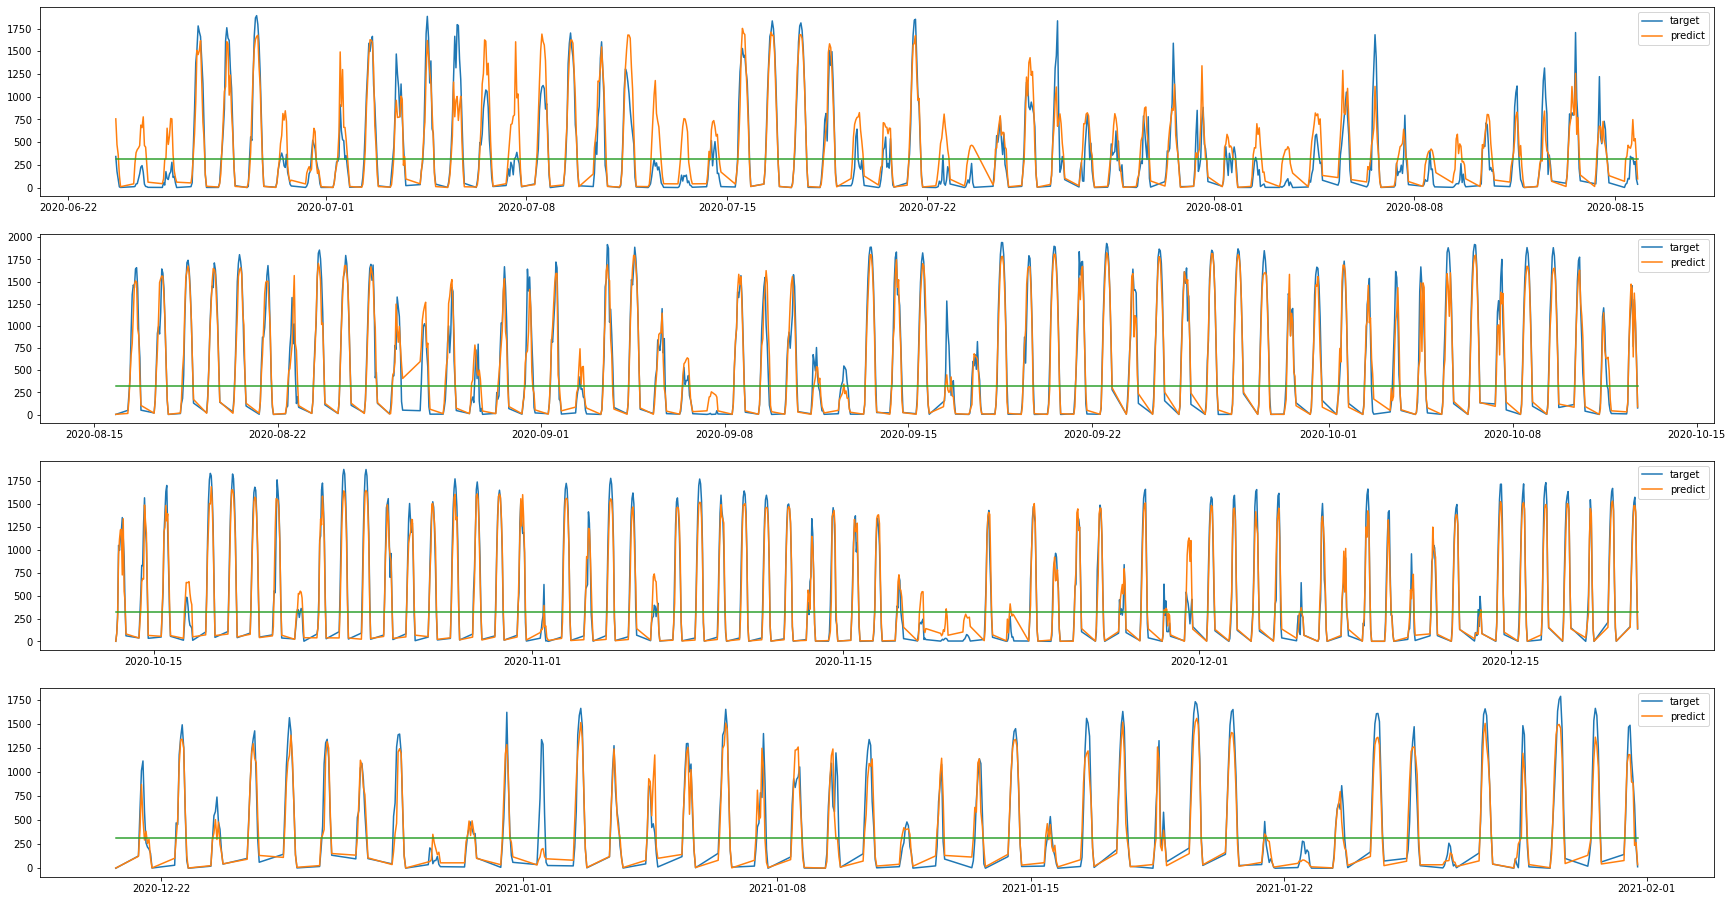

In [82]:
N = 4
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    predict_sample, target_sample = window(predict, test_y, window_start=24*30*n, window_size=24*30)

    ax[n].plot(target_sample, label='target')
    ax[n].plot(pd.Series(predict_sample, index=target_sample.index), label='predict')
    ax[n].plot(target_sample.index, [320 for _ in target_sample.index])
    ax[n].legend()

## Hall of Fame
- 376114: x_cols_fcst; min_sample_leaf=4